O1    0.25
O2    0.40
O3    0.35
Name: states, dtype: float64
Sum of initial state probabilities: 1.0

Transition Matrix:
       O1    O2   O3
O1   0.4   0.2  0.4
O2  0.45  0.45  0.1
O3  0.45  0.25  0.3

Matrix Values:
 [[0.4 0.2 0.4]
 [0.45 0.45 0.1]
 [0.45 0.25 0.3]] (3, 3)

Row Sums (should be 1):
 O1    1.0
O2    1.0
O3    1.0
dtype: object
{('O1', 'O1'): 0.4,
 ('O1', 'O2'): 0.2,
 ('O1', 'O3'): 0.4,
 ('O2', 'O1'): 0.45,
 ('O2', 'O2'): 0.45,
 ('O2', 'O3'): 0.1,
 ('O3', 'O1'): 0.45,
 ('O3', 'O2'): 0.25,
 ('O3', 'O3'): 0.3}


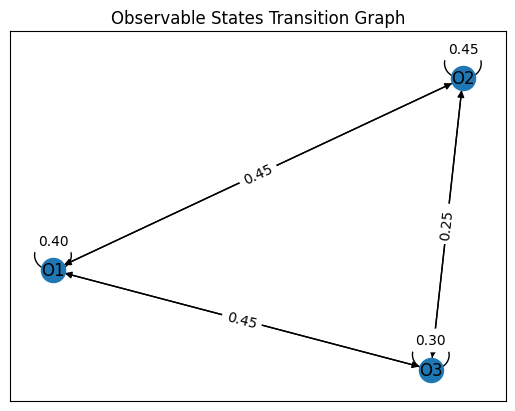


Initial Probabilities:
 S1    0.5
S2    0.5
Name: states, dtype: float64
Sum: 1.0

Hidden Transition Matrix:
      S1   S2
S1  0.7  0.3
S2  0.4  0.6

Matrix Values:
 [[0.7 0.3]
 [0.4 0.6]]
Shape: (2, 2)
Row Sums: S1    1.0
S2    1.0
dtype: object

Emission Matrix:
      O1   O2   O3
S1  0.2  0.6  0.2
S2  0.4  0.1  0.5

Matrix Values:
 [[0.2 0.6 0.2]
 [0.4 0.1 0.5]]
Shape: (2, 3)
Row Sums: S1    1.0
S2    1.0
dtype: object
{('S1', 'S1'): 0.7, ('S1', 'S2'): 0.3, ('S2', 'S1'): 0.4, ('S2', 'S2'): 0.6}
{('S1', 'O1'): 0.2,
 ('S1', 'O2'): 0.6,
 ('S1', 'O3'): 0.2,
 ('S2', 'O1'): 0.4,
 ('S2', 'O2'): 0.1,
 ('S2', 'O3'): 0.5}


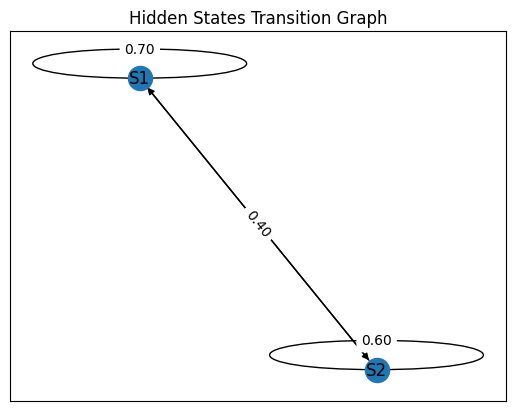

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pprint import pprint

states = ['O1', 'O2', 'O3']
pi_obs = [0.25, 0.4, 0.35]

state_space = pd.Series(pi_obs, index=states, name='states')
print(state_space)
print("Sum of initial state probabilities:", state_space.sum())

q_df = pd.DataFrame(columns=states, index=states)
q_df.loc[states[0]] = [0.4, 0.2, 0.4]
q_df.loc[states[1]] = [0.45, 0.45, 0.1]
q_df.loc[states[2]] = [0.45, 0.25, 0.3]
print("\nTransition Matrix:\n", q_df)

q = q_df.values
print("\nMatrix Values:\n", q, q.shape)
print("\nRow Sums (should be 1):\n", q_df.sum(axis=1))

def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx, col)] = Q.loc[idx, col]
    return edges

edges_wts = _get_markov_edges(q_df)
pprint(edges_wts)

G = nx.MultiDiGraph()
G.add_nodes_from(states)
for (src, dst), weight in edges_wts.items():
    G.add_edge(src, dst, weight=weight, label=f"{weight:.2f}")

pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos, with_labels=True, arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Observable States Transition Graph")
plt.show()

hidden_states = ['S1', 'S2']
pi = [0.5, 0.5]

state_space = pd.Series(pi, index=hidden_states, name='states')
print("\nInitial Probabilities:\n", state_space)
print("Sum:", state_space.sum())

a_df = pd.DataFrame(columns=hidden_states, index=hidden_states)
a_df.loc[hidden_states[0]] = [0.7, 0.3]
a_df.loc[hidden_states[1]] = [0.4, 0.6]
print("\nHidden Transition Matrix:\n", a_df)

a = a_df.values
print("\nMatrix Values:\n", a)
print("Shape:", a.shape)
print("Row Sums:", a_df.sum(axis=1))

observable_states = states
b_df = pd.DataFrame(columns=observable_states, index=hidden_states)
b_df.loc[hidden_states[0]] = [0.2, 0.6, 0.2]
b_df.loc[hidden_states[1]] = [0.4, 0.1, 0.5]
print("\nEmission Matrix:\n", b_df)

b = b_df.values
print("\nMatrix Values:\n", b)
print("Shape:", b.shape)
print("Row Sums:", b_df.sum(axis=1))

hide_edges_wts = _get_markov_edges(a_df)
emit_edges_wts = _get_markov_edges(b_df)

pprint(hide_edges_wts)
pprint(emit_edges_wts)

G = nx.MultiDiGraph()
G.add_nodes_from(hidden_states)
for (src, dst), weight in hide_edges_wts.items():
    G.add_edge(src, dst, weight=weight, label=f"{weight:.2f}")

pos = nx.spring_layout(G, seed=24)
nx.draw_networkx(G, pos, with_labels=True, arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Hidden States Transition Graph")
plt.show()

obs_seq = ['O2', 'O1', 'O3']
obs_map = {state: idx for idx, state in enumerate(observable_states)}
obs_idx_seq = [obs_map[obs] for obs in obs_seq]

n_states = len(hidden_states)
T = len(obs_seq)

delta = np.zeros((T, n_states))
psi = np.zeros((T, n_states), dtype=int)

for i in range(n_states):
    delta[0, i] = pi[i] * b[i, obs_idx_seq[0]]

for t in range(1, T):
    for j in range(n_states):
        max_prob = -1
        for i in range(n_states):
            prob = delta[t-1, i] * a[i, j] * b[j, obs_idx_seq[t]]
            if prob > max_prob:
                max_prob = prob
                psi[t, j] = i
        delta[t, j] = max_prob

path = np.zeros(T, dtype=int)
path[T-1] = np.argmax(delta[T-1])
for t in range(T-2, -1, -1):
    path[t] = psi[t+1, path[t+1]]

state_map = {0: 'S1', 1: 'S2'}
state_path = [state_map[v] for v in path]

result = pd.DataFrame({
    'Observation': obs_seq,
    'Best_Path': state_path
})
